In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Transform: normalize images between [-1, 1] (because Tanh will be used at output)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.94MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.07MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.63MB/s]


In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, img_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, img_dim),
            nn.Tanh()  # Because we normalized images to [-1, 1]
        )

    def forward(self, z):
        return self.model(z)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Outputs probability between 0 and 1
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
noise_dim = 100
img_dim = 28 * 28

# Models
generator = Generator(noise_dim, img_dim).to(device)
discriminator = Discriminator(img_dim).to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Loss
criterion = nn.BCELoss()

In [ ]:
def show_generated_images(epoch, generator, fixed_noise):
    generator.eval()
    with torch.no_grad():
        fake_imgs = generator(fixed_noise).reshape(-1, 1, 28, 28)
        fake_imgs = fake_imgs * 0.5 + 0.5  # De-normalize

    grid = torchvision.utils.make_grid(fake_imgs, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f'Generated Images at Epoch {epoch}')
    plt.axis('off')
    plt.show()
    generator.train()

In [ ]:
def train_gan(train_loader, num_epochs, mode="one_one"):
    fixed_noise = torch.randn(64, noise_dim).to(device)  # For consistent visualization

    for epoch in range(num_epochs):
        for batch_idx, (real, _) in enumerate(train_loader):
            batch_size = real.size(0)
            real = real.view(batch_size, -1).to(device)

            ### Create real and fake labels
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            ### ====================================
            ### 1. Train Discriminator
            ### ====================================

            # Real images
            outputs = discriminator(real)
            d_loss_real = criterion(outputs, real_labels)
            real_score = outputs

            # Fake images
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake.detach())  # detach so gradients don't flow into generator
            d_loss_fake = criterion(outputs, fake_labels)
            fake_score = outputs

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake

            discriminator.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            ### ====================================
            ### 2. Train Generator
            ### ====================================
            # Generate fake images again
            z = torch.randn(batch_size, noise_dim).to(device)
            fake = generator(z)
            outputs = discriminator(fake)

            g_loss = criterion(outputs, real_labels)  # trick discriminator

            generator.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            ### ====================================
            ### 3. Modify according to mode
            ### ====================================
            if mode == "five_gen_one_disc":
                for _ in range(4):  # already did 1 step above
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake)
                    g_loss = criterion(outputs, real_labels)

                    generator.zero_grad()
                    g_loss.backward()
                    g_optimizer.step()

            if mode == "five_disc_one_gen":
                for _ in range(4):  # already did 1 step above
                    # Real
                    outputs = discriminator(real)
                    d_loss_real = criterion(outputs, real_labels)

                    # Fake
                    z = torch.randn(batch_size, noise_dim).to(device)
                    fake = generator(z)
                    outputs = discriminator(fake.detach())
                    d_loss_fake = criterion(outputs, fake_labels)

                    d_loss = d_loss_real + d_loss_fake

                    discriminator.zero_grad()
                    d_loss.backward()
                    d_optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}")
            show_generated_images(epoch+1, generator, fixed_noise)

Training: 1-step Gen, 1-step Disc
Epoch [10/50], D_loss: 0.6388, G_loss: 2.5858


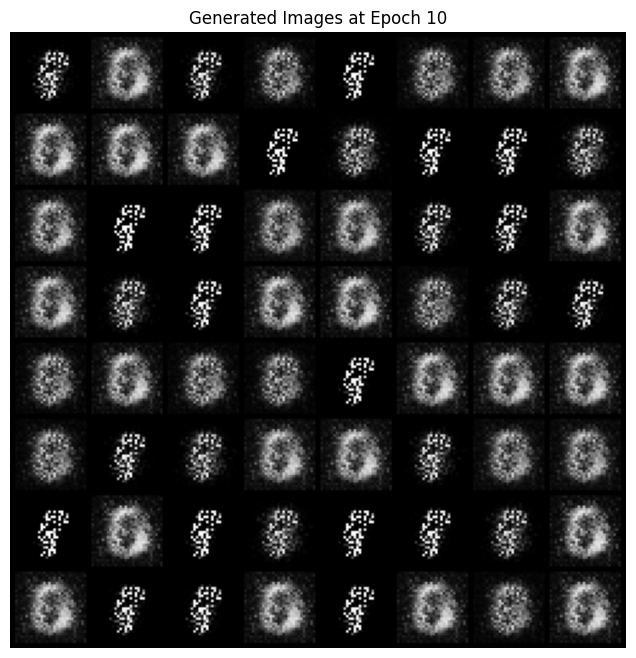

Epoch [20/50], D_loss: 0.5205, G_loss: 5.9698


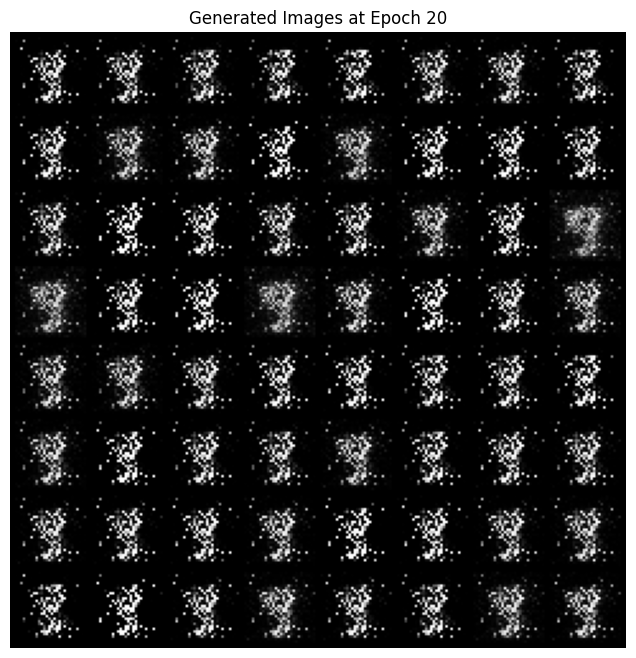

Epoch [30/50], D_loss: 0.7005, G_loss: 2.9473


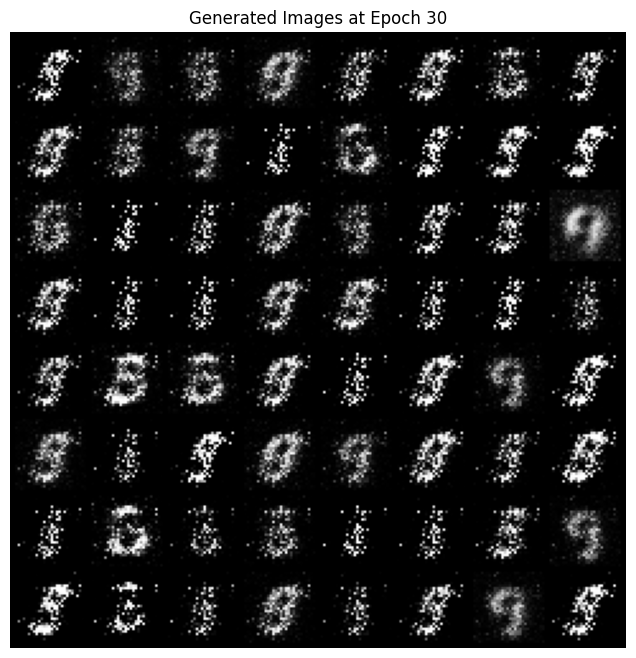

Epoch [40/50], D_loss: 0.5267, G_loss: 3.4727


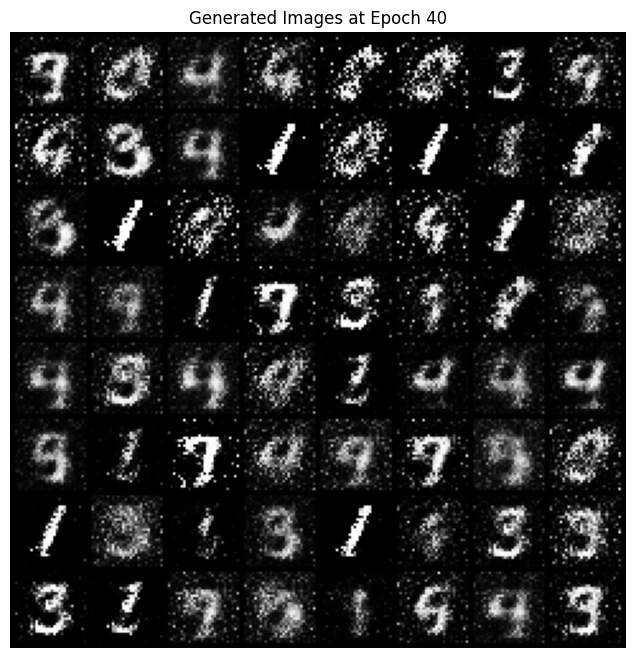

Epoch [50/50], D_loss: 0.6732, G_loss: 2.5412


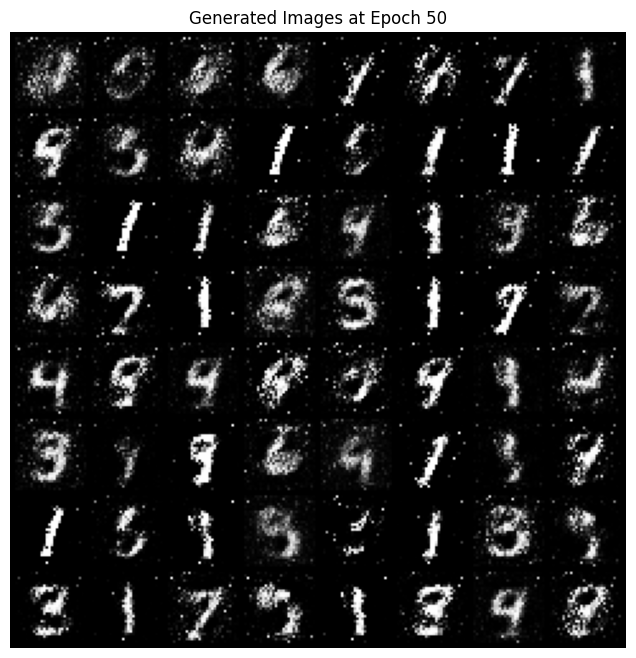

Training: 5-step Gen, 1-step Disc
Epoch [10/50], D_loss: 0.0016, G_loss: 7.9359


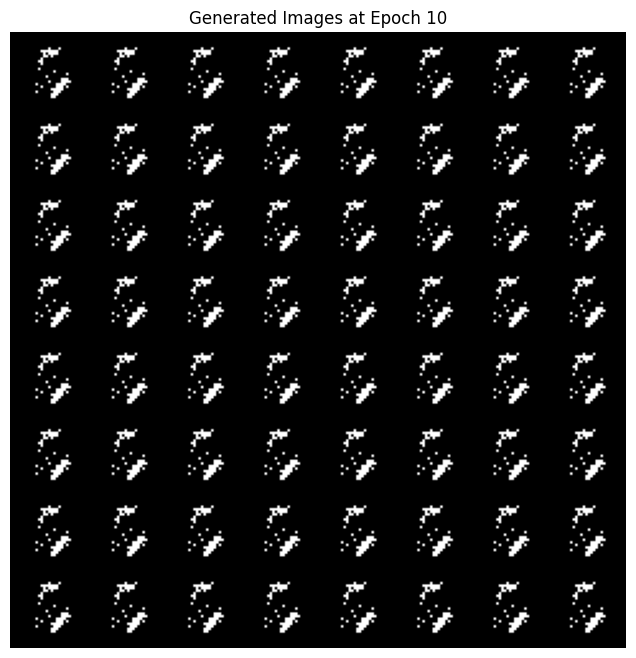

Epoch [20/50], D_loss: 0.0000, G_loss: 12.5609


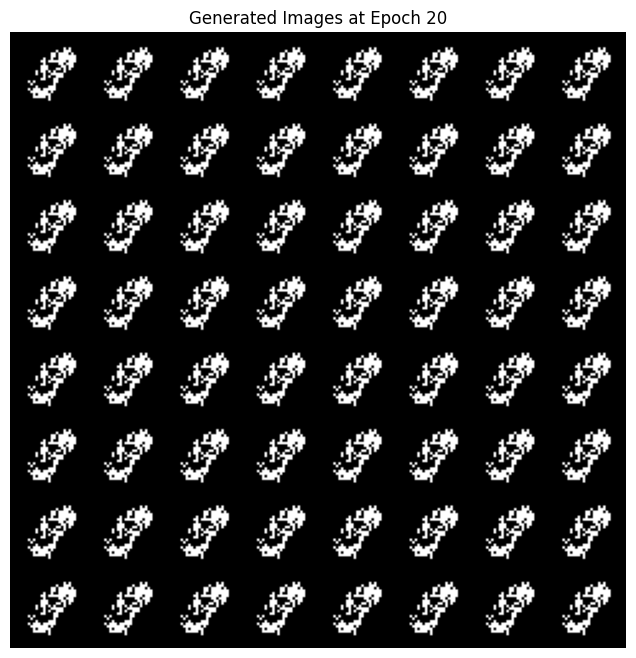

Epoch [30/50], D_loss: 0.0000, G_loss: 14.5957


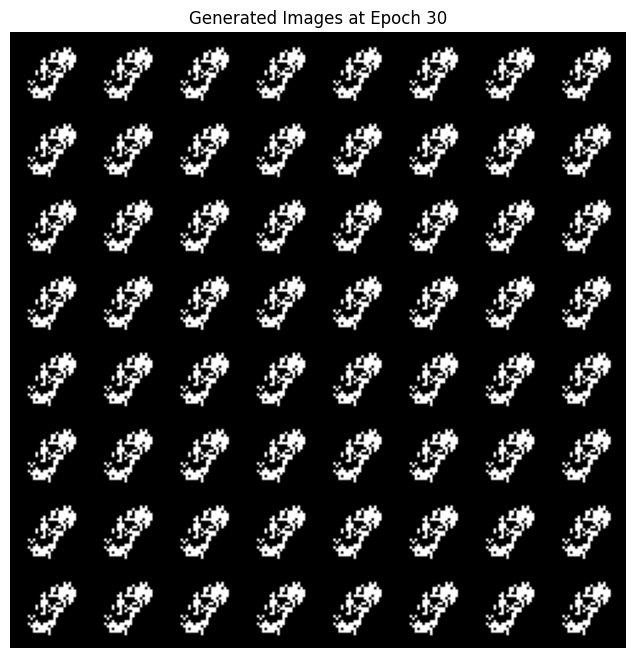

Epoch [40/50], D_loss: 0.0000, G_loss: 13.0992


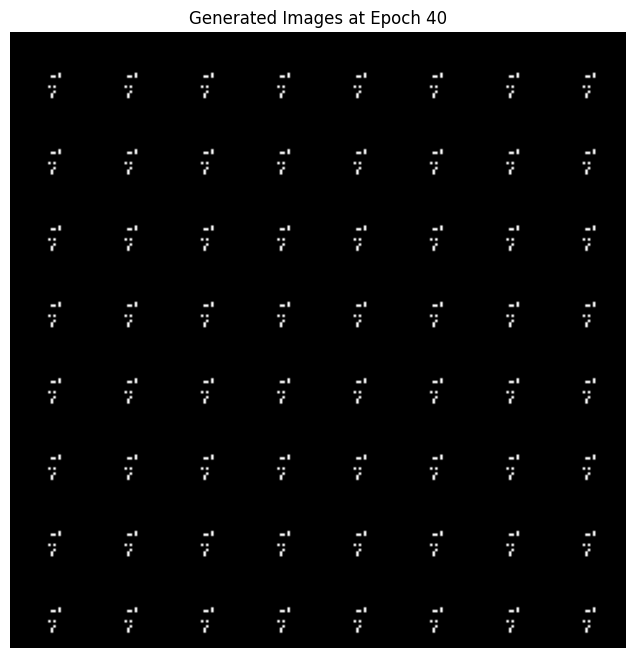

Epoch [50/50], D_loss: 0.0000, G_loss: 15.2045


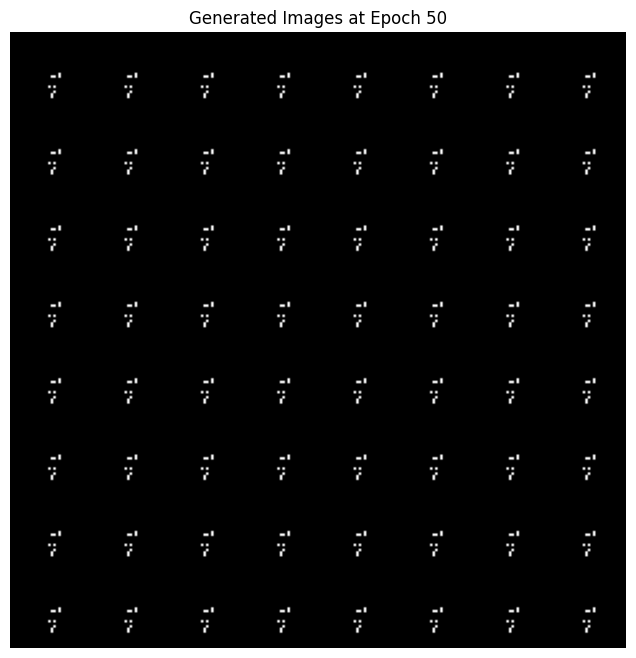

Training: 5-step Disc, 1-step Gen
Epoch [10/50], D_loss: 0.0000, G_loss: 25.8332


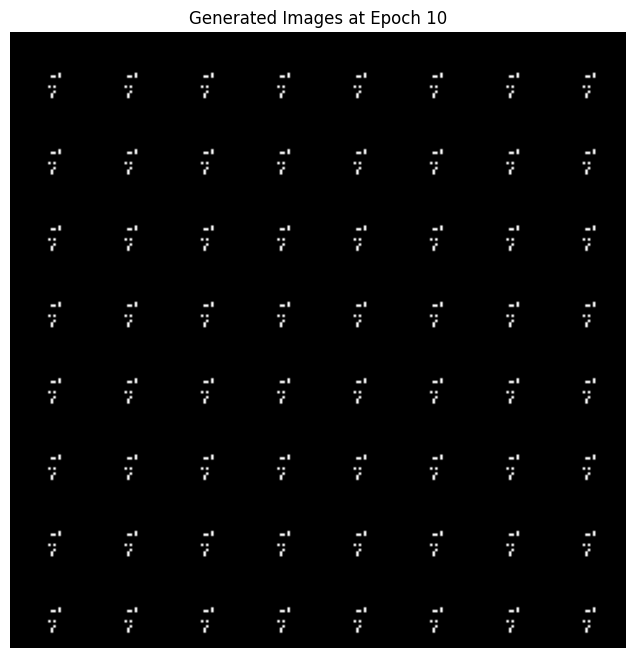

Epoch [20/50], D_loss: 0.0000, G_loss: 28.2154


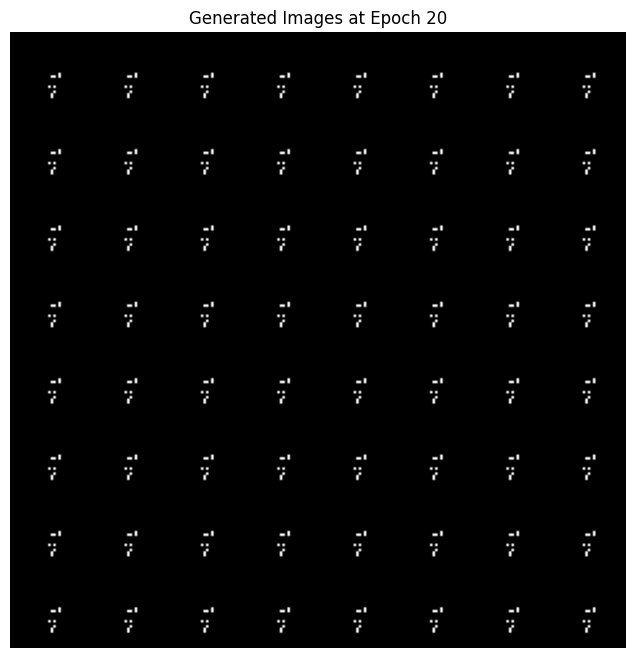

Epoch [30/50], D_loss: 0.0000, G_loss: 28.3775


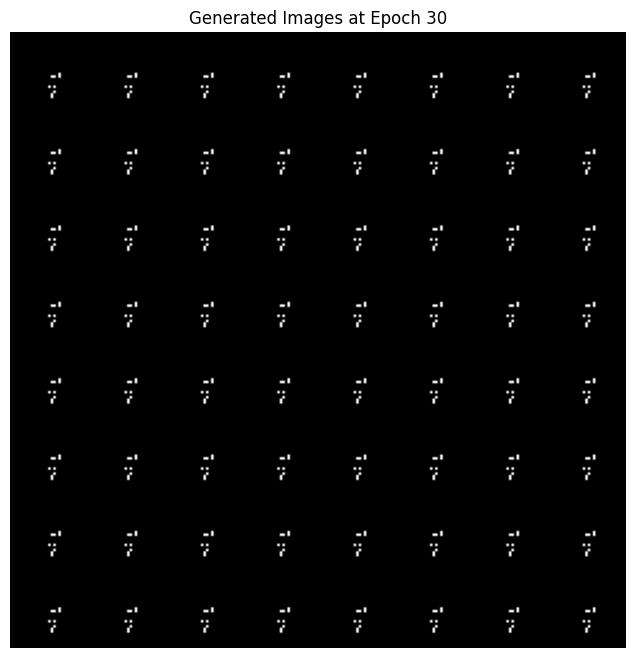

Epoch [40/50], D_loss: 0.0000, G_loss: 28.9002


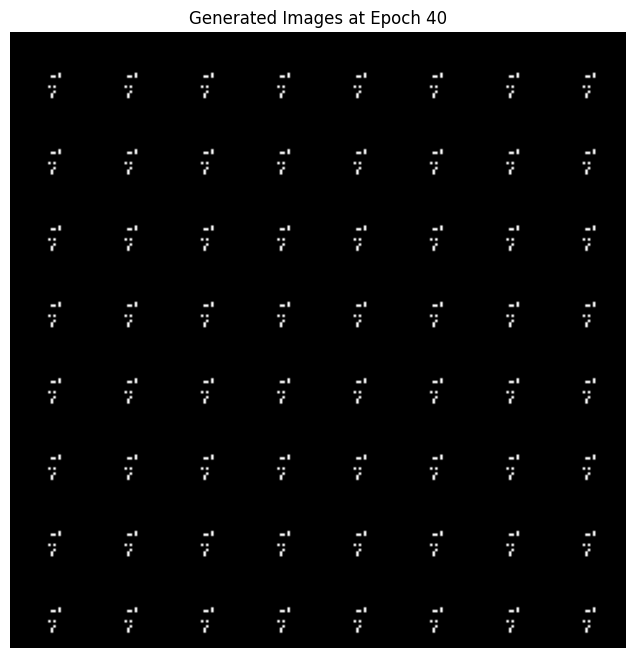

Epoch [50/50], D_loss: 0.0000, G_loss: 28.9342


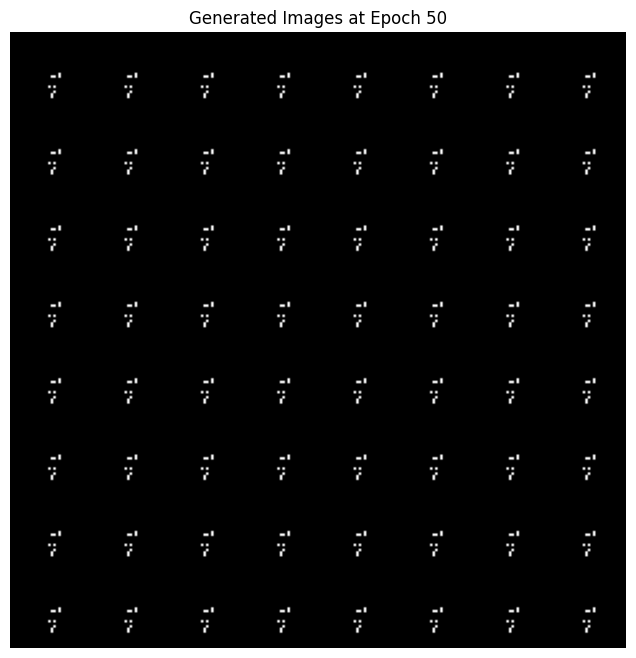

In [ ]:
# 1. Standard: One step Generator, One step Discriminator
print("Training: 1-step Gen, 1-step Disc")
train_gan(train_loader, num_epochs=50, mode="one_one")

# 2. 5 Generator steps, 1 Discriminator step
print("Training: 5-step Gen, 1-step Disc")
train_gan(train_loader, num_epochs=50, mode="five_gen_one_disc")

# 3. 5 Discriminator steps, 1 Generator step
print("Training: 5-step Disc, 1-step Gen")
train_gan(train_loader, num_epochs=50, mode="five_disc_one_gen")